<a href="https://colab.research.google.com/github/rubensolano2/GUIDES-AND-PRACTICES/blob/main/Text_Generation_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OPTIMIZACIÓN DE LOS MODELOS DE LENGUAJE

El modelo llama se ha probado con diferente cantidad de Parametros:

de 7 a 65B de parametros

consiguiendo mejores resultados en su modelos 13B mejores que gpt3 siendo 10 veces mas pequeño

En su modelo de 65B ha conseguido igualar o superar a los grandes modelos de Lenguajes actuales

Los datos son los disponibles en varias páginas y no tiene nada de interesante

#Arquitecturas

#Generación de texto con un RNN

##CONFIGURACIÓN

LIBRERIAS

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

DATASET

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


LEER LOS DATOS

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


##PROCESAR EL TEXTO

###VECTORIZAR EL TEXTO

Antes del entrenamiento, debe convertir las cadenas en una representación numérica.

La capa tf.keras.layers.StringLookup puede convertir cada carácter en un ID numérico. Solo necesita que el texto se divida en tokens primero.

In [ ]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Ahora cree la capa tf.keras.layers.StringLookup :

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

Se convierte de tokens a identificaciones de personajes:

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Dado que el objetivo de este tutorial es generar texto, también será importante invertir esta representación y recuperar cadenas legibles por humanos a partir de ella. Para esto, puede usar tf.keras.layers.StringLookup(..., invert=True) .

- Nota: Aquí, en lugar de pasar el vocabulario original generado con sorted(set(text)) use el método get_vocabulary() de la capa tf.keras.layers.StringLookup para que los tokens [UNK] se configuren de la misma manera.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Esta capa recupera los caracteres de los vectores de ID y los devuelve como un tf.RaggedTensor de caracteres:

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Puede tf.strings.reduce_join para volver a unir los caracteres en cadenas.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

La tarea de predicción


Dado un carácter, o una secuencia de caracteres, ¿cuál es el próximo carácter más probable? Esta es la tarea para la que está entrenando al modelo. La entrada al modelo será una secuencia de caracteres, y usted entrena el modelo para predecir la salida: el siguiente carácter en cada paso de tiempo.

Dado que los RNN mantienen un estado interno que depende de los elementos vistos anteriormente, dados todos los caracteres computados hasta este momento, ¿cuál es el siguiente carácter?



Cree ejemplos y objetivos de capacitación


A continuación, divida el texto en secuencias de ejemplo. Cada secuencia de entrada contendrá caracteres seq_length del texto.

Para cada secuencia de entrada, los objetivos correspondientes contienen la misma longitud de texto, excepto que se desplaza un carácter a la derecha.

Así que divide el texto en partes de seq_length+1 . Por ejemplo, digamos que seq_length es 4 y nuestro texto es "Hola". La secuencia de entrada sería "Hell" y la secuencia de destino "ello".

Para hacer esto, primero use la función tf.data.Dataset.from_tensor_slices para convertir el vector de texto en una secuencia de índices de caracteres.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

El método por batch le permite convertir fácilmente estos caracteres individuales en secuencias del tamaño deseado.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


Es más fácil ver qué está haciendo esto si vuelve a unir los tokens en cadenas:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Para el entrenamiento, necesitará un conjunto de datos de (input, label) pares. Donde input y label son secuencias. En cada paso de tiempo, la entrada es el carácter actual y la etiqueta es el siguiente carácter.

Aquí hay una función que toma una secuencia como entrada, la duplica y la cambia para alinear la entrada y la etiqueta para cada paso de tiempo:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Crear lotes de entrenamiento

Usó tf.data para dividir el texto en secuencias manejables. Pero antes de introducir estos datos en el modelo, debe mezclar los datos y empaquetarlos en lotes.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

###construir el modelo

Esta sección define el modelo como una subclase keras.Model (para obtener más información, consulte Creación de nuevas capas y modelos a través de subclases ).

Este modelo tiene tres capas:

- tf.keras.layers.Embedding : La capa de entrada. Una tabla de búsqueda entrenable que asignará cada ID de carácter a un vector con dimensiones embedding_dim ;
- tf.keras.layers.GRU : un tipo de RNN con units=rnn_units (también puede usar una capa LSTM aquí).
- tf.keras.layers.Dense : la capa de salida, con salidas vocab_size . Produce un logit por cada carácter del vocabulario. Estos son el log-verosimilitud de cada carácter según el modelo.

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

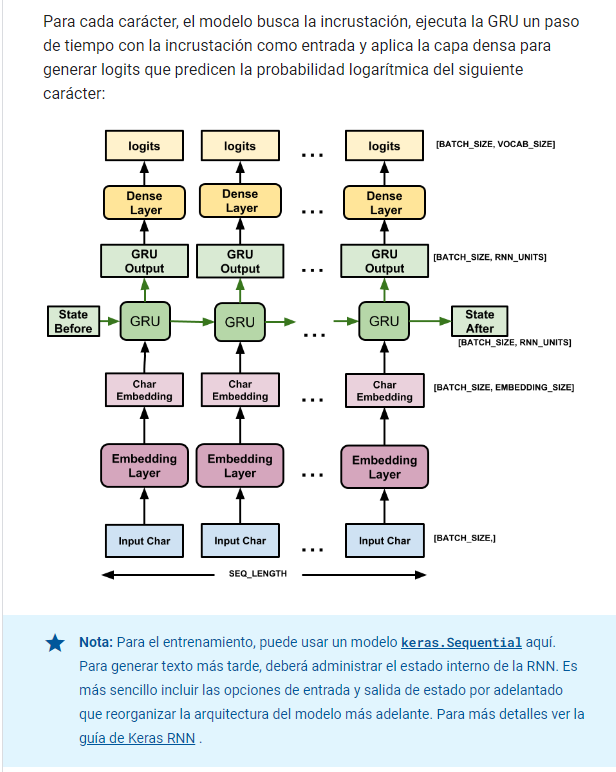

Prueba el modelo

Ahora ejecute el modelo para ver que se comporta como se esperaba.

Primero verifique la forma de la salida:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


En el ejemplo anterior, la longitud de secuencia de la entrada es 100 , pero el modelo se puede ejecutar en entradas de cualquier longitud:

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


Para obtener predicciones reales del modelo, debe muestrear la distribución de salida para obtener índices de caracteres reales. Esta distribución está definida por los logits sobre el vocabulario de caracteres.

Nota: es importante tomar muestras de esta distribución, ya que tomar el argmax de la distribución puede hacer que el modelo se atasque fácilmente en un bucle.

Pruébelo para el primer ejemplo en el lote:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Esto nos da, en cada paso de tiempo, una predicción del siguiente índice de caracteres:

In [ ]:
sampled_indices

array([34,  4,  8, 42,  0,  1, 15, 33, 14, 25, 36, 37, 37, 50, 61,  8, 37,
       48, 54, 46, 50, 25, 45,  2, 44, 63, 63, 42, 15, 44, 45, 30, 12, 12,
        3, 47, 24, 62, 45,  5, 14, 32,  5, 65, 49, 65, 33, 50, 14, 18, 24,
       27, 54,  2,  1, 52, 59, 38, 20, 28, 64, 37, 28, 57, 43, 53, 45, 31,
       45, 34, 54, 12, 22, 19, 29, 39, 49, 11, 53, 43,  2, 32, 18, 48, 39,
        2, 52, 63, 62, 60,  3, 17, 63,  0, 30, 40, 61, 60, 45, 61])

Decodifique estos para ver el texto predicho por este modelo no entrenado:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"thus have wrought you,--for the stone is mine--\nI'ld not have show'd it.\n\nLEONTES:\nDo not draw the c"

Next Char Predictions:
 b'U$-c[UNK]\nBTALWXXkv-XiogkLf exxcBefQ;;!hKwf&AS&zjzTkAEKNo \nmtYGOyXOrdnfRfUo;IFPZj:nd SEiZ mxwu!Dx[UNK]Qavufv'


###entrenar al modelo

En este punto, el problema se puede tratar como un problema de clasificación estándar. Dado el estado anterior de RNN y la entrada de este paso de tiempo, prediga la clase del siguiente carácter.

Adjunte un optimizador y una función de pérdida

La función de pérdida estándar tf.keras.losses.sparse_categorical_crossentropy funciona en este caso porque se aplica en la última dimensión de las predicciones.

Debido a que su modelo devuelve logits, debe configurar el indicador from_logits .

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1890483, shape=(), dtype=float32)


Un modelo recién inicializado no debería estar demasiado seguro de sí mismo, todos los logits de salida deberían tener magnitudes similares. Para confirmar esto puedes comprobar que la exponencial de la pérdida media es aproximadamente igual al tamaño del vocabulario. Una pérdida mucho mayor significa que el modelo está seguro de sus respuestas incorrectas y está mal inicializado:

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.959984

Configure el procedimiento de entrenamiento utilizando el método tf.keras.Model.compile . Utilice tf.keras.optimizers.Adam con argumentos predeterminados y la función de pérdida.

In [ ]:
model.compile(optimizer='adam', loss=loss)

Configurar puntos de control

Use un tf.keras.callbacks.ModelCheckpoint para asegurarse de que los puntos de control se guarden durante el entrenamiento:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Ejecutar el entrenamiento

Para mantener un tiempo de entrenamiento razonable, use 10 épocas para entrenar el modelo. En Colab, configure el tiempo de ejecución en GPU para un entrenamiento más rápido.

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 57ms/step - loss: 2.7045
Epoch 2/20
172/172 [==============================] - 11s 53ms/step - loss: 1.9819
Epoch 3/20
172/172 [==============================] - 11s 53ms/step - loss: 1.7053
Epoch 4/20
172/172 [==============================] - 16s 63ms/step - loss: 1.5473
Epoch 5/20
172/172 [==============================] - 14s 60ms/step - loss: 1.4488
Epoch 6/20
172/172 [==============================] - 13s 60ms/step - loss: 1.3829
Epoch 7/20
172/172 [==============================] - 13s 59ms/step - loss: 1.3304
Epoch 8/20
172/172 [==============================] - 14s 61ms/step - loss: 1.2859
Epoch 9/20
172/172 [==============================] - 13s 62ms/step - loss: 1.2449
Epoch 10/20
172/172 [==============================] - 14s 59ms/step - loss: 1.2068
Epoch 11/20
172/172 [==============================] - 14s 65ms/step - loss: 1.1663
Epoch 12/20
172/172 [==============================] - 13s 60ms/step - loss: 1.1261
E

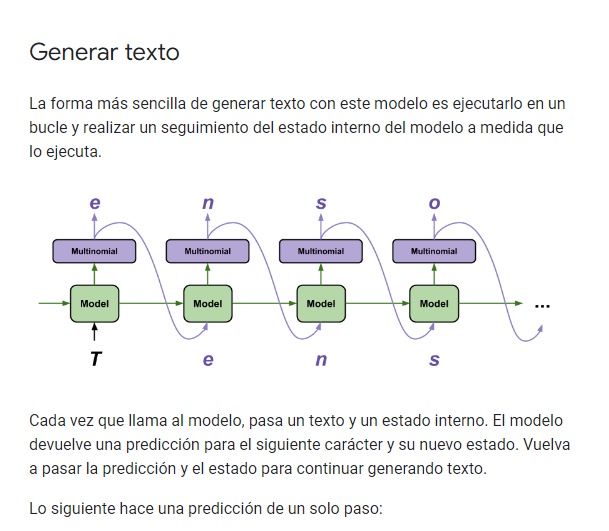

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Ejecútelo en un bucle para generar algo de texto. Mirando el texto generado, verá que el modelo sabe cuándo usar mayúsculas, hacer párrafos e imita un vocabulario de escritura similar al de Shakespeare. Con el pequeño número de épocas de entrenamiento, aún no ha aprendido a formar oraciones coherentes.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Ay, follow you.

Provost:
And, if the day is on unscur! and no man ever dam
intents, impeachest disposition, by your own.
What makes your daughter is Katharina learned.
Courage! might dive this churt? do our mistress,
Her suit resolve you left a man's wife is interpound xouls,
But sunn you from whence is any in Vincenter
As for my presence, where I must be, let's har
behold his bastaph:--for he indeed: he is but a custom,
But nathin be wild and will not see thee mother,
Our high; go to Norfolk desire you:
I'll follow you, sometimes this land of our incient,
Neighbours nothing but in your high hath unreeded,
Amence of napitor's threast, the father of thy soly.

Nurse:

Nurse:
Nor I.

CLARENCE:
By the sentence of his name; he's gone to have.
See, on her king indeed.

DORSET:
I thank you, good God, for whom I am in soul.
Vake next our tiders and quit my plate to them as they
did but one skill we his dear mornight-day,
Death like a poolet am out of shall fold,
accuse his eye, as if 

Lo más fácil que puede hacer para mejorar los resultados es entrenarlo durante más tiempo (pruebe EPOCHS = 30 ).

También puede experimentar con una cadena de inicio diferente, intente agregar otra capa RNN para mejorar la precisión del modelo o ajustar el parámetro de temperatura para generar predicciones más o menos aleatorias.

Si desea que el modelo genere texto más rápido , lo más fácil que puede hacer es generar el texto por lotes. En el siguiente ejemplo, el modelo genera 5 salidas aproximadamente en el mismo tiempo que se tardó en generar 1 arriba

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nCome, sir, a noble and the queen's attend on here.\n\nHENRY BOLINGBROKE:\nSweetly, have talk'd some house, in the reason\nFor meech and now by gaunt: is it next,\nYou had not-like bearing wonder of the whole,\nLess imposed at grace and tales by me?\n\nRIVERS:\nThen he shall close the market-place nor power to this.\nFar we like in great turned.\n\nSICINIUS:\nWas efter so, my lord:\nWhat's your wife?\n\nPedant:\nShe's year-blood upon a soldier's head, say.\n\nOXFORD:\nIn traitor, Marcius, they learn crag-gold\nnot what we warping me?\n\nBISHOP OF CALLLLY:\nMy lord; why stay he hath appears nought:\nBut elbow it was, or else twenty years,\nAnd rike forgery all intolment. Come, come, go a deed.\n\nKING HENRY VI:\nHave done thee speak briefly we are upon you all:\nThe prince my father, or the throwers, rove,\nUnder him o'clock?\nWhere are those joy\nNothing have nothing else beloved of;\nYet, in the seench like aduet: may I change you, sir,\nHe thinks it with a little

Exportar el generador

Este modelo de un solo paso se puede guardar y restaurar fácilmente, lo que le permite usarlo en cualquier lugar donde se acepte un tf.saved_model .

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Knock the traitor, kneel doth kiscA: the duke a
bely shadows of the Tower, of tackly: 'tis nooth, b


###Avanzado: Entrenamiento Personalizado

l procedimiento de entrenamiento anterior es simple, pero no le da mucho control. Utiliza el maestro forzado que evita que las malas predicciones se retroalimenten al modelo, por lo que el modelo nunca aprende a recuperarse de los errores.

Entonces, ahora que ha visto cómo ejecutar el modelo manualmente, ahora implementará el ciclo de entrenamiento. Esto brinda un punto de partida si, por ejemplo, desea implementar el aprendizaje del plan de estudios para ayudar a estabilizar la salida de bucle abierto del modelo.

La parte más importante de un ciclo de entrenamiento personalizado es la función de paso de entrenamiento.

Use tf.GradientTape para rastrear los degradados. Puede obtener más información sobre este enfoque leyendo la guía de ejecución ansiosa .

El procedimiento básico es:



1.   Ejecute el modelo y calcule la pérdida bajo un tf.GradientTape .
2.   Calcule las actualizaciones y aplíquelas al modelo utilizando el optimizador.






In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

La implementación anterior del método train_step sigue las convenciones train_step de Keras . Esto es opcional, pero le permite cambiar el comportamiento del paso de tren y seguir usando los métodos Model.compile y Model.fit de keras.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

O si necesita más control, puede escribir su propio ciclo de entrenamiento personalizado completo:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))